In [3]:
from typing import TypedDict, Optional, List, Dict 

class AgentState(TypedDict):
    question: str
    result : List[Dict]
    selected_index: Optional[int]
    deep_summary: Optional[str]
    feedback: str
    history: List[int]  # 이전에 본 것들 추적
    
    


In [4]:
from langchain.tools import tool

In [ ]:
import os 
from dotenv import load_dotenv

load_dotenv()

os.environ["TAVILY_API_KEY"]
os.environ["GOOGLE_API_KEY"]
os.environ["OPENAI_API_KEY"]

True

In [6]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults()

In [150]:
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langchain.prompts import ChatPromptTemplate
from langgraph.graph import StateGraph, END
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage
from typing import List
from langchain_community.tools.tavily_search import TavilySearchResults

import operator
from typing import Annotated, Sequence
from typing_extensions import TypedDict
from langchain_core.messages import BaseMessage

from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState

# Tavily tool (실제 API 키 필요)
tavily_tool = TavilySearchResults(k=5)

class AgentState(TypedDict):
    messages: Annotated[
        Sequence[BaseMessage], operator.add
    ]  
    sender: Annotated[str, "The sender of the last message"] 
    user_feedback: str
    
# OpenAI 모델
# researcher = ChatOpenAI(model="gpt-4o-2024-11-20")

from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )
    
research_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    state_modifier=make_system_prompt(
        "당신은 검색을 통해 내용을 정리해주는 전문적인 리서치 엔지니어 입니다. 들어오는 데이터를 기반으로 내용을 정리해야합니다."
        "내용은 제목, 서론, 본론 등으로 나누어 정리해주세요."
    ),
)


def research_node(state: AgentState) -> AgentState:
    result = research_agent.invoke(state)
    last_message = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return {
        "messages": [last_message],
        "user_feedback": "",  # 피드백은 다음 노드에서 받음
    }


In [151]:
def user_feedback_node(state: AgentState) -> AgentState:
    # 실제 서비스에서는 여기에 사용자 입력을 받는 로직 추가
    print("유저에게 보여줄 메시지:", state["messages"][-1].content)
    
    # 지금은 시뮬레이션 (ex: "심화 정리" or "그대로 좋아요")
    feedback = input()  # 여기에 따라 분기 처리

    return {
        **state,
        "user_feedback": feedback,
        "sender": "user"
    }


In [152]:
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

workflow = StateGraph(AgentState)
workflow.add_node("researcher", research_node)
workflow.add_edge(START, "researcher")
workflow.add_edge("researcher", END)

app = workflow.compile(checkpointer=MemorySaver(), interrupt_after=["researcher"])

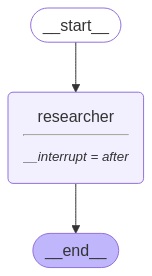

In [153]:
app

In [154]:
from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import random_uuid, invoke_graph

config = RunnableConfig(recursion_limit=10, configurable={"thread_id": random_uuid()})

inputs = {
    "messages": [
        HumanMessage(
            content="2010년 ~ 2024년까지의 대한민국의 1인당 GDP 추이를 그래프로 시각화 해주세요."
        )
    ],
}

In [155]:
invoke_graph(app, inputs, config, node_names=["researcher"]) 


🔄 Node: researcher 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
================================ Human Message =================================
Name: researcher

2010년부터 2024년까지 대한민국 1인당 GDP 추이를 그래프로 시각화하는 데 필요한 구체적인 데이터를 찾지 못했습니다. 검색 결과에서 1인당 GDP와 관련된 정보를 제공하는 웹사이트들을 찾았지만, 해당 기간의 데이터를 표 형태로 제공하는 사이트는 없었습니다. 

하지만, Trading Economics 사이트에서 2023년까지의 1인당 GDP 데이터와 2024년, 2025년 예상치를 확인할 수 있었습니다. 또한, 한국은행, CEIC, KOSIS 등에서 1인당 GDP와 관련된 추가 정보를 얻을 수 있을 것으로 예상됩니다.

다음 단계로, 그래프 시각화를 위해 2010년부터 2023년까지의 1인당 GDP 데이터를 표 형태로 정리하고, 2024년 예상치를 추가하여 그래프를 생성해야 합니다.  데이터를 찾으면 matplotlib 또는 seaborn과 같은 라이브러리를 사용하여 그래프를 만들 수 있습니다.
user_feedback:

